In [1]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten,Conv2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential, load_model, save_model, Model
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import pickle
import tempfile
from tensorflow.python.keras.layers import deserialize, serialize
from tensorflow.python.keras.saving import saving_utils

In [2]:

def unpack(model, training_config, weights):
    restored_model = deserialize(model)
    if training_config is not None:
        restored_model.compile(
            **saving_utils.compile_args_from_training_config(
                training_config
            )
        )
    restored_model.set_weights(weights)
    return restored_model

# Hotfix function
def make_keras_picklable():

    def __reduce__(self):
        model_metadata = saving_utils.model_metadata(self)
        training_config = model_metadata.get("training_config", None)
        model = serialize(self)
        weights = self.get_weights()
        return (unpack, (model, training_config, weights))

    cls = Model
    cls.__reduce__ = __reduce__

# Run the function
make_keras_picklable()


In [3]:
# re sizing all images
IMAGE_SIZE = [224, 224]

train_path = 'cell_images/Train'
valid_path = 'cell_images/Test'

In [4]:
# Importing the Vgg 16 
model1 = VGG19(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [5]:

# don't train existing weights
for layer in model1.layers:
    layer.trainable = False

In [6]:
folders = glob('Dataset/Train/*')

In [7]:
folders

['Dataset/Train\\Parasite', 'Dataset/Train\\Uninfected']

In [8]:

# our layers - you can add more if you want
x = Flatten()(model1.output)

In [9]:

prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model = Model(inputs=model1.input, outputs=prediction)

In [10]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [11]:

from tensorflow.keras.layers import MaxPooling2D

In [12]:
model=Sequential()
model.add(Conv2D(filters=16,kernel_size=2,padding="same",activation="relu",input_shape=(224,224,3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32,kernel_size=2,padding="same",activation ="relu"))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64,kernel_size=2,padding="same",activation="relu"))
model.add(MaxPooling2D(pool_size=2))
model.add(Flatten())
model.add(Dense(500,activation="relu"))
model.add(Dense(2,activation="softmax"))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 16)      208       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 32)      2080      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 64)        8256      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 50176)             0

In [13]:
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [15]:
training_set = train_datagen.flow_from_directory('Dataset/Train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 416 images belonging to 2 classes.


In [16]:

training_set

In [17]:
test_set = test_datagen.flow_from_directory('Dataset/Test',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 134 images belonging to 2 classes.


In [18]:
r = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=50,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
13/13 [==============================] - 27s 2s/step - loss: 1.7049 - accuracy: 0.5337 - val_loss: 0.7586 - val_accuracy: 0.3209
Epoch 2/50
13/13 [==============================] - 19s 1s/step - loss: 0.6869 - accuracy: 0.5409 - val_loss: 0.6827 - val_accuracy: 0.5672
Epoch 3/50
13/13 [==============================] - 18s 1s/step - loss: 0.6700 - accuracy: 0.5673 - val_loss: 0.6517 - val_accuracy: 0.6791
Epoch 4/50
13/13 [==============================] - 17s 1s/step - loss: 0.6388 - accuracy: 0.6226 - val_loss: 0.6951 - val_accuracy: 0.5075
Epoch 5/50
13/13 [==============================] - 18s 1s/step - loss: 0.5137 - accuracy: 0.7332 - val_loss: 1.0355 - val_accuracy: 0.3731
Epoch 6/50
13/13 [==============================] - 18s 1s/step - loss: 0.4343 - accuracy: 0.7812 - val_loss: 0.8200 - val_accuracy: 0.5224
Epoch 7/50
13/13 [==============================] - 18s 1s/step - loss: 0.3211 - acc

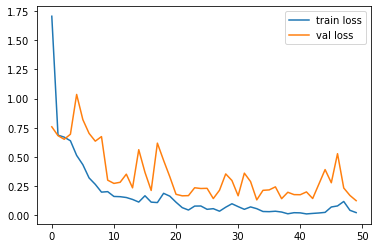

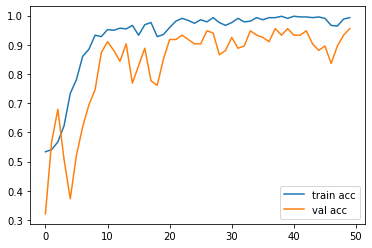

<Figure size 432x288 with 0 Axes>

In [19]:
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [20]:
#model.save("model.h5")

In [21]:
with open('model.pkl', 'wb') as f:
    pickle.dump(model, f)

In [22]:
y_pred = model.predict(test_set)

In [23]:

y_pred

array([[1.00000000e+00, 6.30437746e-14],
       [1.00000000e+00, 3.50069659e-19],
       [9.99999881e-01, 1.51209804e-07],
       [1.00000000e+00, 2.73890084e-08],
       [1.00000000e+00, 1.74945317e-15],
       [3.46664432e-03, 9.96533394e-01],
       [6.76408827e-01, 3.23591143e-01],
       [1.00000000e+00, 2.09749583e-14],
       [1.05662253e-02, 9.89433825e-01],
       [1.00000000e+00, 1.85184690e-09],
       [1.00000000e+00, 1.26277243e-17],
       [6.99936273e-03, 9.93000627e-01],
       [1.00000000e+00, 4.69845256e-12],
       [6.29577041e-03, 9.93704259e-01],
       [1.00000000e+00, 1.45276000e-10],
       [1.00000000e+00, 3.52990305e-19],
       [9.78917897e-01, 2.10821368e-02],
       [1.00000000e+00, 0.00000000e+00],
       [5.62201347e-03, 9.94377911e-01],
       [1.00000000e+00, 8.00081001e-10],
       [7.25555122e-02, 9.27444458e-01],
       [4.76303045e-03, 9.95236993e-01],
       [3.73664349e-02, 9.62633550e-01],
       [3.30226496e-02, 9.66977358e-01],
       [5.640868

In [24]:
y_pred.shape

(134, 2)

In [25]:

import numpy as np
y_pred = np.argmax(y_pred, axis=1)

In [26]:

y_pred

array([0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1,
       0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       1, 1], dtype=int64)

In [27]:
#from tensorflow.keras.models import load_model


In [28]:
from PIL import Image

In [29]:
img = Image.open('Dataset/Test/Parasite/8.png')

In [30]:
basewidth = 224
baseheight = 224
img1 = Image.open('Dataset/Test/Parasite/8.png')
wpercent = (basewidth / float(img.size[0]))
hpercent = (baseheight / float(img.size[1]))
img1 = img1.resize((basewidth, baseheight), Image.ANTIALIAS)

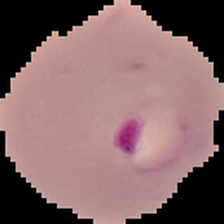

In [31]:
img1

In [32]:
#model=load_model('model_vgg19.h5')

In [33]:
with open('./model.pkl', 'rb') as f:
            loaded_model = pickle.load(f)


In [34]:
from numpy import asarray

In [35]:
x = asarray(img1)
x

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

In [36]:

x=x/255

In [37]:
x.shape

(224, 224, 3)

In [38]:
x1 = x.reshape(-1,224,224,3)

In [39]:
y =loaded_model.predict(x1)


In [40]:
a=np.argmax(y)

In [41]:
a

0

In [42]:
if(a==1):
    print("Uninfected")
else:
    print("Infected")

Infected
